In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Вычтем среднее арифметическое
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Добавим канал с единицами как постоянное смещение
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Разделим train на train и val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [5]:
def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [6]:
# Реализовали softmax и cross-entropy для единичной выборки
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Убедились, что с большими числами также работает
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# Реализовали функцию, объединяющую softmax и cross entropy и вычисляющую градиент
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float64))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [9]:
np.random.seed(42)
# Тест batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int32)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Тест batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float64)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int32)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Снова убедимся, что нормирование работает для больших чисел в каждом батче.
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [10]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float64)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float64)
target_index = np.ones(batch_size, dtype=np.int32)
loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [11]:
# Реализовали функцию l2_regularization, вычисляющую ошибку для L2 регуляризации
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [12]:
# Реализовали функцию LinearSoftmaxClassifier.fit
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 690.883617
Epoch 1, loss: 688.211508
Epoch 2, loss: 685.841336
Epoch 3, loss: 683.710981
Epoch 4, loss: 681.806399
Epoch 5, loss: 680.090137
Epoch 6, loss: 678.596557
Epoch 7, loss: 677.321790
Epoch 8, loss: 676.472948
Epoch 9, loss: 676.264172


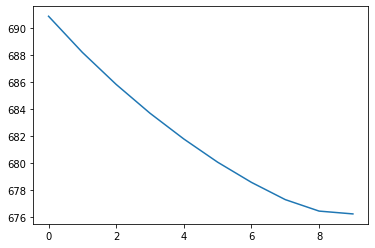

In [13]:
# Посмотрим историю изменения ошибки!
plt.plot(loss_history)

In [14]:
# TODO: Реализовать функцию вычисления точности и посмотреть точность обучения
pred = classifier.predict(val_X)
print(pred)
print(val_y)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Теперь возьмем больше эпох, меньшую скорость обучения и посмотрим как изменится точность
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-4, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

[2 2 5 1 1 1 1 3 1 1 1 1 3 2 5 2 1 1 1 2 1 1 1 1 1 2 2 1 3 2 3 3 1 1 1 1 1
 1 2 1 2 2 2 2 3 2 1 1 2 1 1 1 0 5 1 2 2 3 2 1 2 1 3 1 1 2 1 1 1 1 2 1 1 1
 1 1 3 1 3 2 1 3 2 7 2 3 1 1 1 1 1 3 1 1 1 1 1 3 3 3 1 1 1 2 1 2 1 2 2 3 2
 2 3 2 1 3 2 7 1 1 1 3 2 1 2 3 1 1 1 3 1 1 2 2 2 1 1 1 2 1 1 2 2 2 2 1 1 5
 1 1 1 1 1 1 1 2 5 1 1 2 1 1 1 1 3 2 1 6 1 2 3 1 1 1 1 5 1 1 2 2 1 1 1 1 1
 1 2 2 1 1 2 1 1 5 1 1 2 1 1 1 3 1 3 1 2 1 2 2 2 1 1 2 1 1 5 2 1 1 1 3 1 1
 1 2 1 3 1 1 1 3 1 1 1 1 1 3 1 1 1 3 1 1 1 3 1 1 1 2 1 1 1 1 2 1 3 1 1 2 1
 1 1 3 3 1 1 1 2 1 3 1 1 1 1 2 1 2 1 3 1 1 1 3 5 1 2 2 1 1 1 1 2 3 1 2 7 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 3 1 1 1 1 2 3 1 6 2 2 5 2 5 2 1 1 1 1 3 6 1 1 1
 1 1 1 2 1 3 5 2 5 1 2 1 1 1 1 3 1 2 1 2 2 1 3 2 1 1 2 5 1 1 1 1 7 1 1 3 3
 2 1 2 1 2 1 1 3 1 1 3 1 2 1 1 3 1 1 2 1 1 1 1 5 3 2 1 1 3 1 1 1 1 2 1 1 2
 1 3 1 3 1 7 1 1 1 1 6 1 1 1 1 2 1 1 1 3 1 1 2 7 7 2 1 1 2 7 1 6 1 1 1 5 1
 1 2 1 1 1 1 1 6 3 3 1 2 3 1 3 1 1 1 1 1 2 1 1 3 3 1 2 2 1 1 2 3 1 2 2 1 2
 1 1 2 5 1 1 1 1 1 1 2 3 

### Как и раньше, используем кросс-валидацию для подбора гиперпараметров.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [21]:
num_epochs = 100
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

# словарь
accMap = {} 

for i in range(3):
    for j in range (3):
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=learning_rates[i], batch_size=batch_size, reg=reg_strengths[j])
        pred = classifier.predict(val_X)
        print(learning_rates[i], reg_strengths[j],"-", multiclass_accuracy(pred, val_y));
        key = i
        accMap[str(i) + "," + str(j)] = multiclass_accuracy(pred, val_y)

#{'0,0': 0.204,        
# '0,1': 0.186,
# '0,2': 0.18,
# '1,0': 0.236,
# '1,1': 0.241,
# '1,2': 0.252,
# '2,0': 0.253,
# '2,1': 0.253,
# '2,2': 0.254}

#bestClass.append(classifier.predict(val_X))
#best_classifier = max(bestClass)
print(accMap)
best_val_accuracy = max(bestAcc)

# TODO: используя набор данных для валидации найти лучшие гиперпараметры
print('Best cross-validation accuracy: %f' % best_val_accuracy)

Epoch 0, loss: 735.177058
Epoch 1, loss: 721.690580
Epoch 2, loss: 739.277113
Epoch 3, loss: 730.188472
Epoch 4, loss: 753.539611
Epoch 5, loss: 735.940524
Epoch 6, loss: 752.079509
Epoch 7, loss: 732.643130
Epoch 8, loss: 746.760634
Epoch 9, loss: 728.543049
Epoch 10, loss: 741.597774
Epoch 11, loss: 725.922472
Epoch 12, loss: 738.066165
Epoch 13, loss: 727.435826
Epoch 14, loss: 739.657788
Epoch 15, loss: 740.906360
Epoch 16, loss: 755.379842
Epoch 17, loss: 771.554526
Epoch 18, loss: 770.423610
Epoch 19, loss: 775.359758
Epoch 20, loss: 751.134110
Epoch 21, loss: 760.763719
Epoch 22, loss: 735.442017
Epoch 23, loss: 746.550242
Epoch 24, loss: 717.737459
Epoch 25, loss: 726.330702
Epoch 26, loss: 697.265927
Epoch 27, loss: 704.238051
Epoch 28, loss: 675.828450
Epoch 29, loss: 679.813099
Epoch 30, loss: 652.719801
Epoch 31, loss: 651.442783
Epoch 32, loss: 628.277750
Epoch 33, loss: 622.677448
Epoch 34, loss: 615.156855
Epoch 35, loss: 616.447448
Epoch 36, loss: 625.411206
Epoch 37, l

Epoch 3, loss: 639.081762
Epoch 4, loss: 627.935613
Epoch 5, loss: 621.835834
Epoch 6, loss: 618.369785
Epoch 7, loss: 616.295604
Epoch 8, loss: 614.991448
Epoch 9, loss: 614.133655
Epoch 10, loss: 613.544641
Epoch 11, loss: 613.122236
Epoch 12, loss: 612.805388
Epoch 13, loss: 612.556544
Epoch 14, loss: 612.352103
Epoch 15, loss: 612.176984
Epoch 16, loss: 612.021435
Epoch 17, loss: 611.879091
Epoch 18, loss: 611.745766
Epoch 19, loss: 611.618695
Epoch 20, loss: 611.496041
Epoch 21, loss: 611.376581
Epoch 22, loss: 611.259495
Epoch 23, loss: 611.144236
Epoch 24, loss: 611.030435
Epoch 25, loss: 610.917842
Epoch 26, loss: 610.806290
Epoch 27, loss: 610.695662
Epoch 28, loss: 610.585881
Epoch 29, loss: 610.476891
Epoch 30, loss: 610.368653
Epoch 31, loss: 610.261141
Epoch 32, loss: 610.154334
Epoch 33, loss: 610.048217
Epoch 34, loss: 609.942778
Epoch 35, loss: 609.838007
Epoch 36, loss: 609.733897
Epoch 37, loss: 609.630439
Epoch 38, loss: 609.527629
Epoch 39, loss: 609.425460
Epoch 40

Epoch 6, loss: 595.946500
Epoch 7, loss: 595.944286
Epoch 8, loss: 595.942073
Epoch 9, loss: 595.939862
Epoch 10, loss: 595.937652
Epoch 11, loss: 595.935443
Epoch 12, loss: 595.933235
Epoch 13, loss: 595.931028
Epoch 14, loss: 595.928823
Epoch 15, loss: 595.926619
Epoch 16, loss: 595.924416
Epoch 17, loss: 595.922214
Epoch 18, loss: 595.920013
Epoch 19, loss: 595.917814
Epoch 20, loss: 595.915616
Epoch 21, loss: 595.913418
Epoch 22, loss: 595.911223
Epoch 23, loss: 595.909028
Epoch 24, loss: 595.906834
Epoch 25, loss: 595.904642
Epoch 26, loss: 595.902451
Epoch 27, loss: 595.900261
Epoch 28, loss: 595.898072
Epoch 29, loss: 595.895885
Epoch 30, loss: 595.893698
Epoch 31, loss: 595.891513
Epoch 32, loss: 595.889329
Epoch 33, loss: 595.887146
Epoch 34, loss: 595.884965
Epoch 35, loss: 595.882784
Epoch 36, loss: 595.880605
Epoch 37, loss: 595.878427
Epoch 38, loss: 595.876250
Epoch 39, loss: 595.874074
Epoch 40, loss: 595.871899
Epoch 41, loss: 595.869726
Epoch 42, loss: 595.867554
Epoch

NameError: name 'bestAcc' is not defined

# Какой же точности мы добились на тестовых данных?

In [22]:
best_classifier = linear_classifer.LinearSoftmaxClassifier()
best_classifier.fit(test_X, test_y, epochs=300, learning_rate=1e-5, batch_size=250, reg=1e-6)
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Epoch 0, loss: 575.729569
Epoch 1, loss: 575.638310
Epoch 2, loss: 575.549375
Epoch 3, loss: 575.462652
Epoch 4, loss: 575.378033
Epoch 5, loss: 575.295418
Epoch 6, loss: 575.214710
Epoch 7, loss: 575.135817
Epoch 8, loss: 575.058653
Epoch 9, loss: 574.983133
Epoch 10, loss: 574.909179
Epoch 11, loss: 574.836718
Epoch 12, loss: 574.765676
Epoch 13, loss: 574.695987
Epoch 14, loss: 574.627587
Epoch 15, loss: 574.560414
Epoch 16, loss: 574.494410
Epoch 17, loss: 574.429521
Epoch 18, loss: 574.365693
Epoch 19, loss: 574.302876
Epoch 20, loss: 574.241025
Epoch 21, loss: 574.180092
Epoch 22, loss: 574.120036
Epoch 23, loss: 574.060816
Epoch 24, loss: 574.002393
Epoch 25, loss: 573.944730
Epoch 26, loss: 573.887793
Epoch 27, loss: 573.831548
Epoch 28, loss: 573.775963
Epoch 29, loss: 573.721010
Epoch 30, loss: 573.666658
Epoch 31, loss: 573.612881
Epoch 32, loss: 573.559654
Epoch 33, loss: 573.506951
Epoch 34, loss: 573.454749
Epoch 35, loss: 573.403027
Epoch 36, loss: 573.351763
Epoch 37, l

Epoch 299, loss: 563.357063
Linear softmax classifier test set accuracy: 0.223000
